In [1]:
#import packages and functions

%load_ext autoreload
%autoreload 2

import pursuit_functions as pursuit
    
import pandas as pd
import numpy as np
import random
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
#load data set

all_pursuit_tasks = pd.read_parquet("ca1_ca3_rsc_pursuit_data.parquet", engine="pyarrow")

In [3]:
#drop NA values for RSC, CA1, and CA3 sessions
RSC_sessions = all_pursuit_tasks[all_pursuit_tasks["region"] == "RSC"]
CA1_sessions = all_pursuit_tasks[all_pursuit_tasks["region"] == "CA1"]
CA3_sessions = all_pursuit_tasks[all_pursuit_tasks["region"] == "CA3"]

def drop_NA_vals(dataframe):
    cleaned_data = dataframe.dropna(subset=['ratPos_1', 'ratPos_2', 'laserPos_1', 'laserPos_2'])
    return cleaned_data

RSC_sessions_cleaned = drop_NA_vals(RSC_sessions)
CA1_sessions_cleaned = drop_NA_vals(CA1_sessions)
CA3_sessions_cleaned = drop_NA_vals(CA3_sessions)

In [7]:
#get all coordinate values below 99th percentile and normalize points 

def normalize_points(dataframe, rat_x, rat_y, laser_x, laser_y):

    normalized_data = []
    
    for sessFile in dataframe["sessFile"].unique():
        session = dataframe[dataframe["sessFile"] == sessFile].dropna(subset=[rat_x, rat_y, laser_x, laser_y]).copy()

        region = dataframe['region'][0]

        rat_x_vals = session[rat_x].values.astype("float64")
        rat_y_vals = session[rat_y].values.astype("float64")
        laser_x_vals = session[laser_x].values.astype("float64")
        laser_y_vals = session[laser_y].values.astype("float64")

        x = np.concatenate((rat_x_vals, laser_x_vals))
        y = np.concatenate((rat_y_vals, laser_y_vals))

        #identify 99th percentile x, y boundaries
        x_low, x_high = np.percentile(x, [1, 99])
        y_low, y_high = np.percentile(y, [1, 99])

        #filter the data so we only get the data under the 99th percentile
        filter = (x >= x_low) & (x <= x_high) & (y >= y_low) & (y <= y_high)

        x_filtered = x[filter]
        y_filtered = y[filter]

        #normalize the points to the origin
        x_normalized = x_filtered - x_low
        y_normalized = y_filtered - y_low

        for xn, yn in zip(x_normalized, y_normalized):
            normalized_data.append({
                "sessFile": sessFile,
                "region": region,
                "x_normalized": xn,
                "y_normalized": yn,
                "x_low": x_low,
                "x_high": x_high, 
                "y_low": y_low, 
                "y_high": y_high
            })
            
    normalized_df = pd.DataFrame(normalized_data)
    return normalized_df

normalized_sessions = normalize_points(all_pursuit_tasks, "ratPos_1", "ratPos_2", "laserPos_1", "laserPos_2")
#normalized_sessions.head()
        

In [8]:
#boundary approach: find center of arena and radius to find boundaries for all normalized data points
def circle_fit_bounds(dataframe, x_norm, y_norm, radius_percentile=95):
    
    results = []

    all_x_vals = dataframe[x_norm].values.astype("float64")
    all_y_vals = dataframe[y_norm].values.astype("float64")

    overall_center_x = np.mean(all_x_vals)
    overall_center_y = np.mean(all_y_vals)

    overall_distances = np.sqrt((all_x_vals - overall_center_x)**2 + (all_y_vals - overall_center_y)**2)

    overall_radius = np.percentile(overall_distances, radius_percentile)

    for sessFile in dataframe["sessFile"].unique():
        session = dataframe[dataframe["sessFile"] == sessFile]
        region = dataframe['region'][0]

        session_x_vals = session[x_norm].values.astype("float64")
        session_y_vals = session[y_norm].values.astype("float64")

        x_min = np.min(session_x_vals)
        x_max = np.max(session_x_vals)
        y_min = np.min(session_y_vals)
        y_max = np.max(session_y_vals)

        center_x = (x_min + x_max) / 2
        center_y = (y_min + y_max) / 2

        results.append({
            "sessFile": sessFile,
            "region": region,
            "center_x": center_x,
            "center_y": center_y,
            "x_min": x_min,
            "x_max": x_max,
            "y_min": y_min,
            "y_max": y_max,
            "radius": overall_radius
        })

    
    center_radius_vals = pd.DataFrame(results)

    return center_radius_vals, overall_radius

   
normalized_center_radius, radius = circle_fit_bounds(normalized_sessions, "x_normalized", "y_normalized", radius_percentile=95)

print(radius)
#normalized_center_radius.head()




61.179933135984626


In [ ]:
#find circle boundary points
def circ_bounds(dataframe, center_x, center_y, radius):
    
    results = []

    for sessFile in dataframe["sessFile"].unique():
        session = dataframe[dataframe["sessFile"] == sessFile]

        x_val = session[center_x].values.astype("float64")
        y_val = session[center_y].values.astype("float64")
        r = session[radius].values.astype("float64")

        num_points = 360

        angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)

        x_points = x_val + r * np.cos(angles)
        y_points = y_val + r * np.sin(angles)

        results.append({
            "sessFile": sessFile,
            "x_bounds": x_points,
            "y_bounds": y_points,
            "radius": r
        })
    
    session_bound_radius_vals = pd.DataFrame(results)


    return session_bound_radius_vals

#circumference, x_circ, y_circ = circ_bounds(mean_center_x, mean_center_y, mean_radius)
all_circ_bounds = circ_bounds(normalized_center_radius, "center_x", "center_y", "radius")


all_circ_bounds.head()


In [ ]:
#plot normalized concatenated laser and rat paths with center point and boundary
for sessFile in normalized_sessions["sessFile"].unique():
    subset_sessFile = normalized_sessions[normalized_sessions["sessFile"] == sessFile]
    plt.plot(subset_sessFile["x_normalized"], subset_sessFile["y_normalized"], color='purple', label=f'Session {sessFile}')
    
    subset_center = normalized_center_radius[normalized_center_radius["sessFile"] == sessFile]
    plt.scatter(subset_center["center_x"], subset_center["center_y"], color='black', zorder=5)

    subset_bounds = all_circ_bounds[all_circ_bounds["sessFile"] == sessFile]
    plt.plot(subset_bounds["x_bounds"].iloc[0], subset_bounds["y_bounds"].iloc[0], 'b-', zorder=10, label='Circle Boundary')
   
    plt.axis('equal')
    plt.legend()
    plt.show()

In [9]:
#normalize laser points and make a dataframe containing spike data using the normalized data mask
def normalize_laser_points(dataframe, laser_x, laser_y):

    normalized_laser_data = []

    spk_columns = [col for col in dataframe.columns if "spkTable" in col]
    
    for sessFile in dataframe["sessFile"].unique():

        session = dataframe[dataframe["sessFile"] == sessFile]
        laser_x_vals = session[laser_x].values.astype("float64")
        laser_y_vals = session[laser_y].values.astype("float64")
   
        #identify 99th percentile x, y boundaries
        x_low, x_high = np.percentile(laser_x_vals, [0, 99])
        y_low, y_high = np.percentile(laser_y_vals, [0, 99])

        #filter the data so we only get the data under the 99th percentile
        filter = (laser_x_vals >= x_low) & (laser_x_vals <= x_high) & (laser_y_vals >= y_low) & (laser_y_vals <= y_high)
        x_filtered = laser_x_vals[filter]
        y_filtered = laser_y_vals[filter]

        #normalize the points to the origin
        x_normalized = x_filtered - x_low
        y_normalized = y_filtered - y_low

        #make a dataframe containing normalized data
        normalized_df = pd.DataFrame({
            "sessFile": sessFile,
            "laser_x_normalized": x_normalized,
            "laser_y_normalized": y_normalized
        })

        #make a dataframe containing spike data using the normalized data mask
        spk_df = session.loc[filter, spk_columns].reset_index(drop=True)

        #make a combined dataframe
        combined_df = pd.concat([normalized_df.reset_index(drop=True), spk_df], axis=1)

        #append dataframe to the list
        normalized_laser_data.append(combined_df)

    #make a giant dataframe by concatenating all the dataframes in the list        
    laser_normalized_df = pd.concat(normalized_laser_data, ignore_index=True)

    return laser_normalized_df


RSC_sessions_laser_normalized = normalize_laser_points(RSC_sessions_cleaned, "laserPos_1", "laserPos_2")
CA1_sessions_laser_normalized = normalize_laser_points(CA1_sessions_cleaned, "laserPos_1", "laserPos_2")
CA3_sessions_laser_normalized = normalize_laser_points(CA3_sessions_cleaned, "laserPos_1", "laserPos_2")


In [10]:
#find distance of normalized laser points to boundary

def laser_bound_dist(laser_df, center_df, laser_x, laser_y, center_x, center_y, radius):

    session_df = [] 

    for sessFile in laser_df["sessFile"].unique():
        session = laser_df[laser_df["sessFile"] == sessFile].copy()

        laser_x_val = session[laser_x].values.astype("float64")
        laser_y_val = session[laser_y].values.astype("float64")

        subset_center = center_df[center_df["sessFile"] == sessFile]

        center_x_val = subset_center[center_x].iloc[0]
        center_y_val = subset_center[center_y].iloc[0]
        r = subset_center[radius].iloc[0]

        session["center_dist"] = np.sqrt((laser_x_val - center_x_val)**2 + (laser_y_val - center_y_val)**2)

        session["bound_dist"] = np.abs(session["center_dist"] - r)

        session_df.append(session)

    combined_df = pd.concat(session_df, ignore_index=True)
    return combined_df

RSC_sessions_laser_bounds_spks = laser_bound_dist(RSC_sessions_laser_normalized, normalized_center_radius, "laser_x_normalized", "laser_y_normalized", "center_x", "center_y", "radius")
CA1_sessions_laser_bounds_spks = laser_bound_dist(CA1_sessions_laser_normalized, normalized_center_radius, "laser_x_normalized", "laser_y_normalized", "center_x", "center_y", "radius")
CA3_sessions_laser_bounds_spks = laser_bound_dist(CA3_sessions_laser_normalized, normalized_center_radius, "laser_x_normalized", "laser_y_normalized", "center_x", "center_y", "radius")


In [11]:
#function for calculating bin edges from overall min and max bound_dist values
def find_overall_bin_edges(dataframe, column, num_bins):
    overall_min = dataframe[column].min()
    overall_max = dataframe[column].max()

    bin_edges = np.linspace(overall_min, overall_max, num_bins +1)
    return bin_edges

In [12]:
#put raw spike counts into bins calculated from the overall min and max bound_dist values
def bin_spike_data(dataframe, spk_prefix="spkTable", num_bins=20, bin_edges=None):

    rows = []

    if bin_edges is None:
        bin_edges = find_overall_bin_edges(dataframe, "bound_dist", num_bins)

    for sessFile in dataframe["sessFile"].unique():

        session = dataframe[dataframe["sessFile"] == sessFile].copy()

        session["bound_bin"] = pd.cut(session["bound_dist"], bins=bin_edges, include_lowest=True)

        spk_cols = [col for col in session.columns if spk_prefix in col and not session[col].isna().all()]

        for spk in spk_cols:
            spk_by_bin = session.groupby("bound_bin")[spk].sum()

            bin_midpoints = pd.IntervalIndex.from_breaks(bin_edges).to_series().apply(
                lambda interval: round((interval.left + interval.right) / 2, 2)
                )

            for bin_mid, spk_count in zip(bin_midpoints, spk_by_bin):
                rows.append({
                    "sessFile": sessFile,
                    "neuron": spk,
                    "spike_count": spk_count,
                    "bin_midpoint": bin_mid        
                })

    binned_spks_df = pd.DataFrame(rows)
    return binned_spks_df




In [13]:
#put laser coordinates into bins calculated from the overall min and max bound_dist values
def bin_laser_data(dataframe, laser_x, laser_y, num_bins=20, bin_edges=None):

    rows = []

    if bin_edges is None:
        bin_edges = find_overall_bin_edges(dataframe, "bound_dist", num_bins)

    for sessFile in dataframe["sessFile"].unique():

        session = dataframe[dataframe["sessFile"] == sessFile].copy()

        session["bound_bin"] = pd.cut(session["bound_dist"], bins=bin_edges, include_lowest=True)

        coords_by_bin = session.groupby("bound_bin").size()

        for bin_interval, laser_count in coords_by_bin.items():
            bin_mid = round((bin_interval.left + bin_interval.right) / 2, 2)
            
            rows.append({
                    "sessFile": sessFile,
                    "laser_occupancy": laser_count,
                    "bin_midpoint": bin_mid
                })

    binned_laser_df = pd.DataFrame(rows)
    return binned_laser_df


In [14]:
#bin the data!

RSC_laser_binned = bin_laser_data(RSC_sessions_laser_bounds_spks, "laser_x_normalized", "laser_y_normalized")
CA1_laser_binned = bin_laser_data(CA1_sessions_laser_bounds_spks, "laser_x_normalized", "laser_y_normalized")
CA3_laser_binned = bin_laser_data(CA3_sessions_laser_bounds_spks, "laser_x_normalized", "laser_y_normalized")

RSC_spikes_binned = bin_spike_data(RSC_sessions_laser_bounds_spks)
CA1_spikes_binned = bin_spike_data(CA1_sessions_laser_bounds_spks)
CA3_spikes_binned = bin_spike_data(CA3_sessions_laser_bounds_spks)

/var/folders/k4/zr04khhn74zcj29mf4f0v8hc0000gn/T/ipykernel_74111/3669240961.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  coords_by_bin = session.groupby("bound_bin").size()
/var/folders/k4/zr04khhn74zcj29mf4f0v8hc0000gn/T/ipykernel_74111/3669240961.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  coords_by_bin = session.groupby("bound_bin").size()
/var/folders/k4/zr04khhn74zcj29mf4f0v8hc0000gn/T/ipykernel_74111/3669240961.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or obs

In [15]:
#normalize spike counts by laser occupancy using bins calculated from the overall min and max bound_dist values 

def make_tuning_curve(spike_df, laser_df):

    merged_df = pd.merge(spike_df, laser_df, on=["sessFile", "bin_midpoint"], how="left")

    merged_df["tuning"] = merged_df["spike_count"] / merged_df["laser_occupancy"]

    return merged_df

In [16]:
RSC_binned_tuning = make_tuning_curve(RSC_spikes_binned, RSC_laser_binned)
CA1_binned_tuning = make_tuning_curve(CA1_spikes_binned, CA1_laser_binned)
CA3_binned_tuning = make_tuning_curve(CA3_spikes_binned, CA3_laser_binned)

In [ ]:
def plot_tuning_curves(dataframe):
    
    plt.figure(figsize=(12,8))

    for sessFile in dataframe["sessFile"].unique():

        session = dataframe[dataframe["sessFile"] == sessFile]
        
        pivoted = (session.pivot(index="neuron", columns="bin_midpoint", values="tuning").fillna(0))

        for neuron in pivoted.index:
            plt.plot(pivoted.columns, pivoted.loc[neuron], marker='o', linestyle='-', label=f"{neuron}")

    plt.xlabel("Boundary Distance (bin midpoint)")
    plt.ylabel("Tuning (spike count / laser occupancy)")
    plt.title(f"All Neuron Tuning Curves")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [ ]:
plot_tuning_curves(RSC_binned_tuning)

In [ ]:
RSC_binned_tuning.head()

In [17]:
#z-score binned normalized data

def z_score_norm(dataframe):
    
    sessions = dataframe.copy()
        
    def norm_z(x):
        std = x.std()
        mean = x.mean()
        z = (x - mean) / std if std > 0 else x*0

        z_min, z_max = z.min(), z.max()
        if z_max > z_min:
            return (z - z_min) / (z_max - z_min)
        else:
            return z * 0

        
    sessions["z_score"] = (
        sessions.groupby(["sessFile", "neuron"])["tuning"].transform(norm_z)
    )

    return sessions
        

        

In [18]:
RSC_z_scored = z_score_norm(RSC_binned_tuning)
CA1_z_scored = z_score_norm(CA1_binned_tuning)
CA3_z_scored = z_score_norm(CA3_binned_tuning)

In [ ]:
#z-score data and put them into bins calculated from the overall min and max bound_dist values
def z_score_data(dataframe, spk_prefix="spkTable", num_bins=20, bin_edges=None):

    rows = []
    num_bins = 20

    if bin_edges is None:
        bin_edges = find_overall_bin_edges(dataframe, "bound_dist", num_bins)

    for sessFile in dataframe["sessFile"].unique():

        session = dataframe[dataframe["sessFile"] == sessFile].copy()

        session["bound_bin"] = pd.cut(session["bound_dist"], bins=bin_edges, include_lowest=True)

        spk_cols = [col for col in session.columns if spk_prefix in col and not session[col].isna().all()]

        for spk in spk_cols:
            spk_by_bin = session.groupby("bound_bin")[spk].sum()
            
            #z-score normalized spike counts
            mean_val = spk_by_bin.mean()
            std_val = spk_by_bin.std()
            if std_val > 0:
                z_spk = (spk_by_bin - mean_val) / std_val
            else:
                z_spk = spk_by_bin * 0

            bin_midpoints = pd.IntervalIndex.from_breaks(bin_edges).to_series().apply(
                lambda interval: (interval.left + interval.right) / 2
                )

            for bin_mid, z_val in zip(bin_midpoints, z_spk):
                rows.append({
                    "sessFile": sessFile,
                    "neuron": spk,
                    "bin_midpoint": bin_mid,
                    "z_score": z_val
                })

    z_df = pd.DataFrame(rows)
    return z_df




In [ ]:
#plot heatmap for z-scored data: RSC sessions

pivoted_binned_zscore_neurons = RSC_z_scored.pivot_table(
    index=["sessFile", "neuron"], 
    columns="bin_midpoint", 
    values="z_score"
    ).fillna(0)

plt.figure(figsize=(12,8))

heatmap = sns.heatmap(pivoted_binned_zscore_neurons, cmap="viridis", annot=False, fmt=".2f", yticklabels=False)

x_labels = heatmap.get_xticklabels()

rounded_labels = [f"{float(label.get_text()):.2f}" if label.get_text() != "" else "" for label in x_labels]

heatmap.set_xticklabels(rounded_labels, rotation=45, ha="right")


plt.title(f"Z-scored Spike Activity by Boundary Distance: RSC Sessions")
plt.xlabel("Boundary Distance (bin midpoint)")
plt.ylabel("Neurons")
plt.show()


In [20]:
#pivot table for plotting and apply gaussian smoothing

CA1_pivoted_binned_zscore_neurons = CA1_z_scored.pivot_table(
    index=["sessFile", "neuron"], 
    columns="bin_midpoint", 
    values="z_score"
    ).fillna(0)

CA1_smoothed_neurons = CA1_pivoted_binned_zscore_neurons.apply(
    lambda row: row.rolling(window=3, win_type='gaussian', center=True).mean(std=1), axis=1
    ).fillna(0)

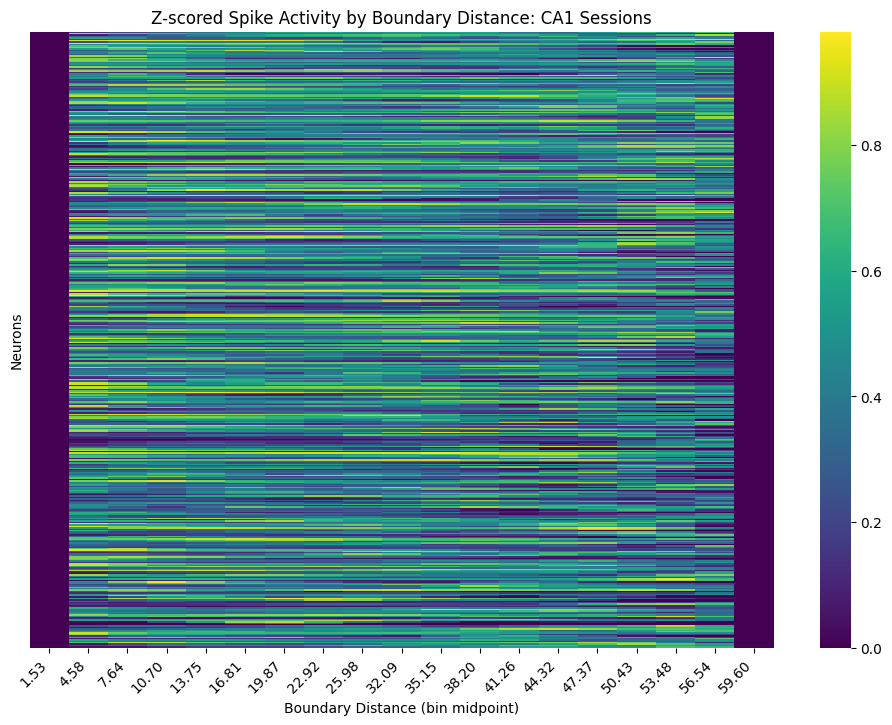

In [21]:
#plot heatmap for z-scored data: CA1 Sessions

plt.figure(figsize=(12,8))

heatmap = sns.heatmap(CA1_smoothed_neurons, cmap="viridis", annot=False, fmt=".2f", yticklabels=False)

x_labels = heatmap.get_xticklabels()

rounded_labels = [f"{float(label.get_text()):.2f}" if label.get_text() != "" else "" for label in x_labels]

heatmap.set_xticklabels(rounded_labels, rotation=45, ha="right")


plt.title(f"Z-scored Spike Activity by Boundary Distance: CA1 Sessions")
plt.xlabel("Boundary Distance (bin midpoint)")
plt.ylabel("Neurons")
plt.show()


In [ ]:
#plot heatmaps for z-scored data: CA3 Sessions

pivoted_binned_zscore_neurons = CA3_z_scored.pivot_table(
    index=["sessFile", "neuron"], 
    columns="bin_midpoint", 
    values="z_score"
    ).fillna(0)

plt.figure(figsize=(12,8))

heatmap = sns.heatmap(pivoted_binned_zscore_neurons, cmap="viridis", annot=False, fmt=".2f", yticklabels=False)

x_labels = heatmap.get_xticklabels()

rounded_labels = [f"{float(label.get_text()):.2f}" if label.get_text() != "" else "" for label in x_labels]

heatmap.set_xticklabels(rounded_labels, rotation=45, ha="right")


plt.title(f"Z-scored Spike Activity by Boundary Distance: CA3 Sessions")
plt.xlabel("Boundary Distance (bin midpoint)")
plt.ylabel("Neurons")
plt.show()

In [ ]:
#number of neurons by sessFile
# Create an empty dictionary to hold the counts for each session.
session_neuron_counts = {}

# Iterate over unique sessions.
for sess in RSC_sessions_laser_bounds_spks["sessFile"].unique():
    # Select only rows for that session.
    session = RSC_sessions_laser_bounds_spks[RSC_sessions_laser_bounds_spks["sessFile"] == sess]
    
    # Identify spkTable columns that are not entirely NaN for this session.
    spk_cols = [col for col in session.columns if "spkTable" in col and not session[col].isna().all()]
    
    # Store the count for this session.
    session_neuron_counts[sess] = len(spk_cols)

# Now print counts per session.
for sess, count in session_neuron_counts.items():
    print(f"Session {sess}: {count} neurons")

# Sum up the counts over all sessions.
total_neurons = sum(session_neuron_counts.values())
print("Total neurons across sessions:", total_neurons)


In [ ]:
#number of neurons by sessFile
# Create an empty dictionary to hold the counts for each session.
session_neuron_counts = {}

# Iterate over unique sessions.
for sess in CA1_sessions_laser_bounds_spks["sessFile"].unique():
    # Select only rows for that session.
    session = CA1_sessions_laser_bounds_spks[CA1_sessions_laser_bounds_spks["sessFile"] == sess]
    
    # Identify spkTable columns that are not entirely NaN for this session.
    spk_cols = [col for col in session.columns if "spkTable" in col and not session[col].isna().all()]
    
    # Store the count for this session.
    session_neuron_counts[sess] = len(spk_cols)

# Now print counts per session.
for sess, count in session_neuron_counts.items():
    print(f"Session {sess}: {count} neurons")

# Sum up the counts over all sessions.
total_neurons = sum(session_neuron_counts.values())
print("Total neurons across sessions:", total_neurons)


In [ ]:
#number of neurons by sessFile
# Create an empty dictionary to hold the counts for each session.
session_neuron_counts = {}

# Iterate over unique sessions.
for sess in CA3_sessions_laser_bounds_spks["sessFile"].unique():
    # Select only rows for that session.
    session = CA3_sessions_laser_bounds_spks[CA3_sessions_laser_bounds_spks["sessFile"] == sess]
    
    # Identify spkTable columns that are not entirely NaN for this session.
    spk_cols = [col for col in session.columns if "spkTable" in col and not session[col].isna().all()]
    
    # Store the count for this session.
    session_neuron_counts[sess] = len(spk_cols)

# Now print counts per session.
for sess, count in session_neuron_counts.items():
    print(f"Session {sess}: {count} neurons")

# Sum up the counts over all sessions.
total_neurons = sum(session_neuron_counts.values())
print("Total neurons across sessions:", total_neurons)
